In [36]:
using ITensors
using Plots
using JLD2
using StatsBase
using HDF5
include("../sampling.jl");

In [3]:
function loadMPS(path::String; id::String="W")
    """Loads an MPS from a .h5 file. Returns and ITensor MPS."""
    file = path[end-2:end] != ".h5" ? path * ".h5" : path
    f = h5open("$file","r")
    mps = read(f, "$id", MPS)
    close(f)
    return mps
end;

In [7]:
mps_loaded = loadMPS("mps_saved.h5");

In [10]:
function sliceMPS(W::MPS, class_label::Int)
    """General function to slice the MPS and return the state corresponding to a specific class label."""
    ψ = deepcopy(W)
    decision_idx = findindex(ψ[end], "f(x)")
    decision_state = onehot(decision_idx => (class_label + 1))
    ψ[end] *= decision_state
    normalize!(ψ) # same step as before - normalise the tensor at the site with the label index instead?

    return ψ
end;

In [11]:
norm(mps_loaded)

1.0000000000000024

In [13]:
state0 = sliceMPS(mps_loaded, 0)
state1 = sliceMPS(mps_loaded, 1);

In [16]:
abs(inner(state0, state1))

3.064210191227821e-12

In [26]:
out = sample_mps_with_contractions(state1);

Prob of sampled state: 0.47567635020124627
Trace of ρ1: 0.999999999999996
Prob of sampled state: 0.6666008149996308
Trace of ρ2: 1.0000000000000002
Prob of sampled state: 0.3292706108700498
Trace of ρ3: 1.0000000000000004
Prob of sampled state: 0.7196401017111299
Trace of ρ4: 0.9999999999999998
Prob of sampled state: 0.6919129073179182
Trace of ρ5: 1.0000000000000004
Prob of sampled state: 0.40865804532428546
Trace of ρ6: 0.9999999999999997
Prob of sampled state: 0.11502280484609784
Trace of ρ7: 0.9999999999999994
Prob of sampled state: 0.6783903909389343
Trace of ρ8: 1.0000000000000004
Prob of sampled state: 0.5491718406210186
Trace of ρ9: 1.0
Prob of sampled state: 0.9493571275579102
Trace of ρ10: 0.9999999999999998
Prob of sampled state: 0.9182746254670977
Trace of ρ11: 0.9999999999999994
Prob of sampled state: 0.7586922399395428
Trace of ρ12: 1.0000000000000004
Prob of sampled state: 0.6665182053490336
Trace of ρ13: 0.9999999999999999
Prob of sampled state: 0.387406958993199
Trace 

In [55]:
all_shots = Matrix{Float64}(undef, 10_000, 100)
for i in 1:10_000
    all_shots[i, :] = sample_mps_with_contractions(state1)
end

In [66]:
mean_ts = mean(all_shots, dims=1)[1,:]
std_ts = std(all_shots, dims=1)[1,:]

100-element Vector{Float64}:
 0.28321035050237275
 0.27861448985880477
 0.27914678047622926
 0.27840710282407166
 0.27939275305029154
 0.285633732148712
 0.28369256979972096
 0.2870561483276863
 0.28195434164261385
 0.2803151820015668
 ⋮
 0.28517339551799836
 0.2807252940900508
 0.27825746802282175
 0.2793588129948111
 0.28370349956591073
 0.28483871792696747
 0.2855438410773642
 0.2851958433311014
 0.2840521068520771

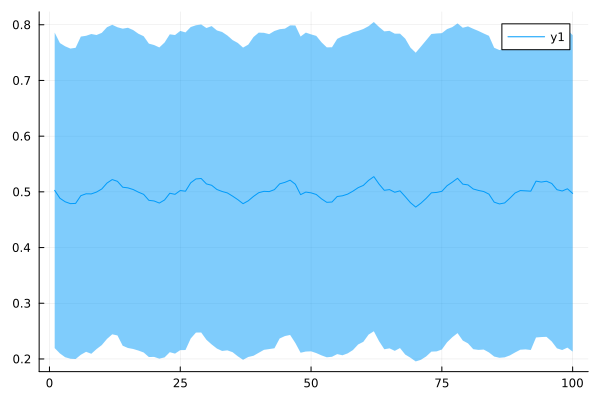

In [67]:
plot(mean_ts, ribbon=std_ts)

In [43]:
@load "train.jld2"

2-element Vector{Symbol}:
 :X_train_scaled
 :y_train

In [48]:
c0_idxs = findall(x -> x.== 0, y_train);
c1_idxs = findall(x -> x.== 1, y_train);
c0_samples = X_train_scaled[c0_idxs, :];
c1_samples = X_train_scaled[c1_idxs, :];

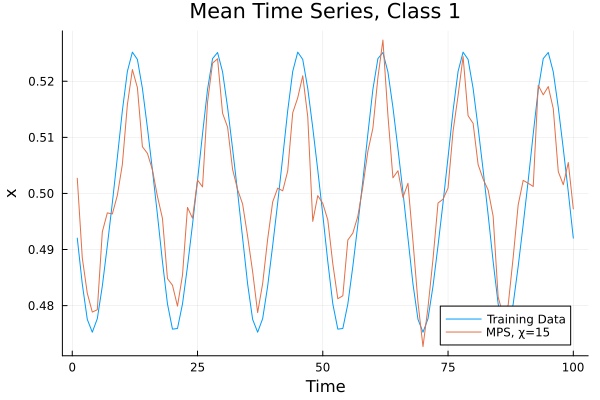

In [76]:
plot(mean(c1_samples, dims=1)[1,:], label="Training Data")
plot!(mean_ts, label="MPS, χ=15")
title!("Mean Time Series, Class 1")
xlabel!("Time")
ylabel!("x")

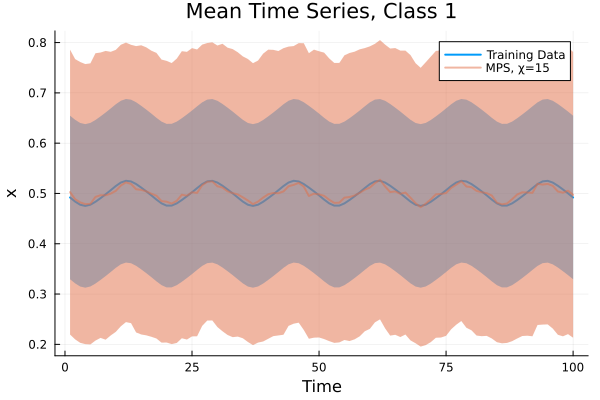

In [77]:
plot(mean(c1_samples, dims=1)[1,:], ribbon=std(c1_samples, dims=1), label="Training Data", lw=2)
plot!(mean_ts, ribbon=std_ts, label="MPS, χ=15", alpha=0.5, lw=2)
title!("Mean Time Series, Class 1")
xlabel!("Time")
ylabel!("x")

In [83]:
all_shots_c0 = Matrix{Float64}(undef, 20_000, 100)
for i in 1:20_000
    all_shots_c0[i, :] = sample_mps_with_contractions(state0)
end

In [84]:
mean_ts = mean(all_shots_c0, dims=1)[1,:]
std_ts = std(all_shots_c0, dims=1)[1,:]

100-element Vector{Float64}:
 0.2855001893397079
 0.2833145342645742
 0.2826758746489932
 0.2812134856602189
 0.28507102068583834
 0.2837437526770107
 0.28376844392481265
 0.28301327214133837
 0.28338506249767337
 0.2826355167538275
 ⋮
 0.28320362287617834
 0.28364758321251277
 0.2844452823352271
 0.2839057066785963
 0.2832156955747911
 0.2817078168033576
 0.284049570381432
 0.2839438189278775
 0.28451698699149147

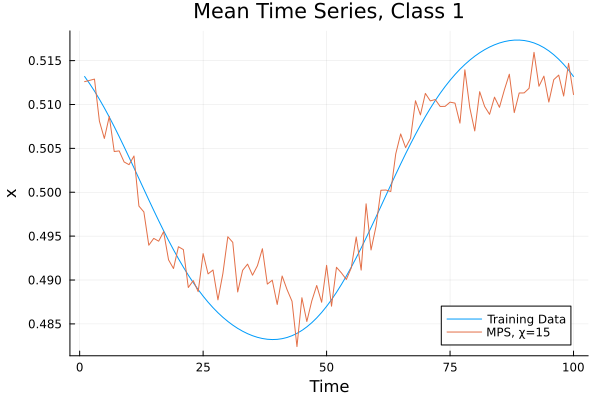

In [85]:
plot(mean(c0_samples, dims=1)[1,:], label="Training Data")
plot!(mean_ts, label="MPS, χ=15")
title!("Mean Time Series, Class 1")
xlabel!("Time")
ylabel!("x")

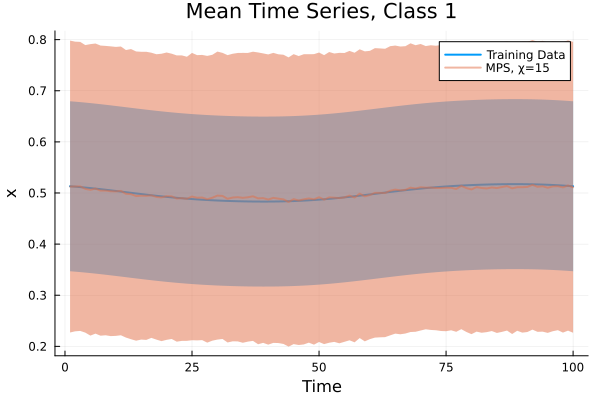

In [86]:
plot(mean(c0_samples, dims=1)[1,:], ribbon=std(c0_samples, dims=1), label="Training Data", lw=2)
plot!(mean_ts, ribbon=std_ts, label="MPS, χ=15", alpha=0.5, lw=2)
title!("Mean Time Series, Class 1")
xlabel!("Time")
ylabel!("x")

Forecast

In [113]:
all_shots_forecast = Matrix{Float64}(undef, 5000, 100)
for i in 1:5000
    all_shots_forecast[i, :] = forecast_mps_sites(state0, c0_samples[10,1:50], 51)
end

In [117]:
@load "test.jld2"

2-element Vector{Symbol}:
 :X_test_scaled
 :y_test

In [118]:
c0_idxs = findall(x -> x.== 0, y_test);
c1_idxs = findall(x -> x.== 1, y_test);
c0_samples = X_test_scaled[c0_idxs, :];
c1_samples = X_test_scaled[c1_idxs, :];

In [119]:
all_shots_forecast = Matrix{Float64}(undef, 1000, 100)
for i in 1:1000
    all_shots_forecast[i, :] = forecast_mps_sites(state0, c0_samples[10,1:50], 51)
end

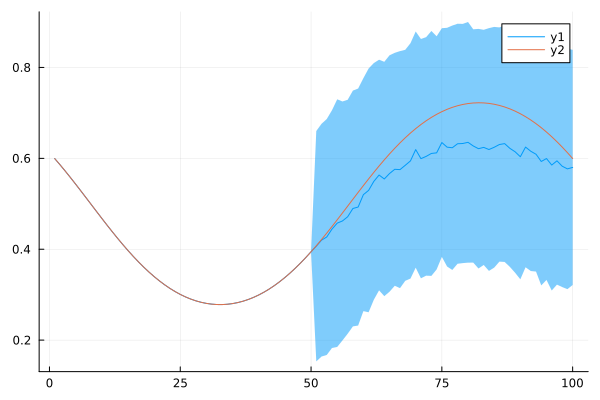

In [123]:
plot(mean(all_shots_forecast, dims=1)[1,:], ribbon=std(all_shots_forecast, dims=1)[1,:])
plot!(c0_samples[10,:])